---

### 🎓 **Professor**: Apostolos Filippas

### 📘 **Class**: AI Engineering

### 📋 **Homework 4**: Embeddings & Semantic Search

### 📅 **Due Date**: Day of Lecture 5, 11:59 PM


**Note**: You are not allowed to share the contents of this notebook with anyone outside this class without written permission by the professor.

---

In this homework, you'll build on Homework 3 (BM25 search) by adding **embedding-based semantic search**.

You will:
1. **Generate embeddings** using both local (Hugging Face) and API (OpenAI) models
2. **Implement cosine similarity** from scratch
3. **Implement semantic search** from scratch
4. **Compare BM25 vs semantic search** using Recall
5. **Compare different embedding models** and analyze their differences

**Total Points: 95**

---

## Instructions

- Complete all tasks by filling in code where you see `# YOUR CODE HERE`
- You may use ChatGPT, Claude, documentation, Stack Overflow, etc.
- When using external resources, briefly cite them in a comment
- Run all cells before submitting to ensure they work

**Submission:**
1. Create a branch called `homework-4`
2. Commit and push your work
3. Create a PR and merge to main
4. Submit the `.ipynb` file on Blackboard

---

## Task 1: Environment Setup (10 points)

### 1a. Imports (5 pts)

Import the required libraries and load the WANDS data.

In [1]:
import os
import sys
import ctypes
import platform
from importlib.util import find_spec

# --- Windows DLL Manual Load Patch ---
if platform.system() == "Windows":
    try:
        # Locate where torch is installed
        spec = find_spec("torch")
        if spec and spec.origin:
            torch_lib_path = os.path.join(os.path.dirname(spec.origin), "lib")
            
            # Add the torch lib folder to the DLL search path
            if hasattr(os, 'add_dll_directory'):
                os.add_dll_directory(torch_lib_path)
            
            # Manually load c10.dll to trigger dependent loading
            c10_path = os.path.join(torch_lib_path, "c10.dll")
            if os.path.exists(c10_path):
                ctypes.CDLL(c10_path)
                print("Successfully manually pre-loaded c10.dll")
    except Exception as e:
        print(f"DLL Patch attempt failed (this is usually okay if it loads later): {e}")

# Now run your standard imports
from sentence_transformers import SentenceTransformer
import litellm
print("Imports successful!")

Successfully manually pre-loaded c10.dll


C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'autocast' from 'torch.amp' (unknown location)

In [3]:
# ruff: noqa: E402

# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings("ignore")

# Import ONLY data loading from helpers
import sys
sys.path.append('../scripts')
from helpers import load_wands_products, load_wands_queries, load_wands_labels

# Embedding libraries - we use these directly
from sentence_transformers import SentenceTransformer
import litellm

# Load environment variables for API keys
from dotenv import load_dotenv
load_dotenv()

pd.set_option('display.max_colwidth', 80)
print("All imports successful!")

All imports successful!


In [6]:
# 1. Define where your data actually lives
data_path = "./data" 

# 2. Pass that path into the functions
products = load_wands_products(data_dir=data_path)
queries = load_wands_queries(data_dir=data_path)
labels = load_wands_labels(data_dir=data_path)

# 3. Check the results
print(f"Products: {len(products):,}")
print(f"Queries: {len(queries):,}")
print(f"Labels: {len(labels):,}")

# Let's see the first few rows of products
products.head()

Products: 42,994
Queries: 480
Labels: 233,448


,product_id,product_name,product_class,category_hierarchy,product_description,product_features,rating_count,average_rating,review_count
0,0,solid wood platform bed,Beds,Furniture / Bedroom Furniture / Beds & Headboards / Beds / Twin Beds,"good , deep sleep can be quite difficult to have in this busy age . fortunat...",overallwidth-sidetoside:64.7|dsprimaryproductstyle : modern|countryoforigin-...,15.0,4.5,15.0
1,1,all-clad 7 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Sl...,"create delicious slow-cooked meals , from tender meat to flavorful veggies ,...",capacityquarts:7|producttype : slow cooker|programmablecookingsettings : slo...,100.0,2.0,98.0
2,2,all-clad electrics 6.5 qt . slow cooker,Slow Cookers,Kitchen & Tabletop / Small Kitchen Appliances / Pressure & Slow Cookers / Sl...,"prepare home-cooked meals on any schedule with this essential slow cooker , ...",features : keep warm setting|capacityquarts:6.5|programmablefoodsettings : s...,208.0,3.0,181.0
3,3,all-clad all professional tools pizza cutter,"Slicers, Peelers And Graters",Browse By Brand / All-Clad,this original stainless tool was designed to complement manufacturer 's cook...,overallwidth-sidetoside:3.5|warrantylength : lifetime|productcare : dishwash...,69.0,4.5,42.0
4,4,baldwin prestige alcott passage knob with round rosette,Door Knobs,Home Improvement / Doors & Door Hardware / Door Hardware & Accessories / Doo...,the hardware has a rich heritage of delivering modern luxury to discriminati...,compatibledoorthickness:1.375 '' |countryoforigin-additionaldetails : philip...,70.0,5.0,42.0


### 1b. Copy BM25 functions from HW3 (5 pts)

Copy your BM25 implementation from Homework 3. We'll use it to compare against semantic search.

In [8]:
import pandas as pd
import numpy as np
from collections import Counter
import string
import Stemmer  # Requires pystemmer: pip install pystemmer

# --- 1. Tokenization & Indexing ---

stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    """Tokenize text with Snowball stemming."""
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    """Build an inverted index: term -> {doc_id: count}."""
    index = {}
    doc_lengths = []
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    return index, doc_lengths

# --- 2. BM25 Scoring Logic ---

def bm25_idf(df: int, num_docs: int) -> float:
    """BM25 Inverse Document Frequency formula."""
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    """BM25 Term Frequency normalization."""
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    """Score all documents using BM25 across a single index."""
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        if token in index:
            df = len(index[token])
            idf = bm25_idf(df, num_docs)
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    return scores

# --- 3. Multi-Field Search ---

def search_tri_field(query: str, products_df: pd.DataFrame, 
                     name_idx: dict, name_lens: list,
                     desc_idx: dict, desc_lens: list,
                     class_idx: dict, class_lens: list,
                     tokenizer, k: int = 10):
    """Combines BM25 scores from Product Name, Description, and Class."""
    num_docs = len(products_df)
    s_name = score_bm25(query, name_idx, num_docs, name_lens, tokenizer)
    s_desc = score_bm25(query, desc_idx, num_docs, desc_lens, tokenizer)
    s_class = score_bm25(query, class_idx, num_docs, class_lens, tokenizer)
    
    # Simple sum combination (weights can be added here)
    total_scores = s_name + s_desc + s_class
    top_k_idx = np.argsort(-total_scores)[:k]
    
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = total_scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

# --- 4. Evaluation (NDCG) ---

def calculate_dcg(scores: list[int], k: int = None) -> float:
    """Calculate Discounted Cumulative Gain."""
    k = k or len(scores)
    dcg = 0.0
    for i, rel in enumerate(scores[:k]):
        dcg += (2**rel - 1) / np.log2(i + 2)
    return dcg

def calculate_ndcg(scores: list[int], k: int = 10) -> float:
    """Calculate Normalized Discounted Cumulative Gain."""
    actual_dcg = calculate_dcg(scores, k)
    ideal_scores = sorted(scores, reverse=True)
    ideal_dcg = calculate_dcg(ideal_scores, k)
    return actual_dcg / ideal_dcg if ideal_dcg > 0 else 0.0

def evaluate_search(search_func, products_df: pd.DataFrame, queries_df: pd.DataFrame,
                    labels_df: pd.DataFrame, k: int = 10) -> pd.DataFrame:
    """Runs search_func against all queries and calculates Mean NDCG."""
    eval_results = []
    # Pre-map labels for fast lookup
    label_dict = labels_df.groupby('query_id').apply(lambda x: dict(zip(x.product_id, x.grade))).to_dict()

    for _, row in queries_df.iterrows():
        q_id, q_text = row['query_id'], row['query']
        results = search_func(q_text)
        p_ids = results['product_id'].tolist()[:k]
        
        # Get grades for results (defaulting to 0 if not in labeled data)
        query_grades = label_dict.get(q_id, {})
        relevances = [query_grades.get(pid, 0) for pid in p_ids]
        
        eval_results.append({'query_id': q_id, 'ndcg': calculate_ndcg(relevances, k)})
    
    res_df = pd.DataFrame(eval_results)
    print(f"Mean NDCG@{k}: {res_df['ndcg'].mean():.4f}")
    return res_df

---

## Task 2: Understanding Embeddings (15 points)

### 2a. Load a local model and generate embeddings (5 pts)

Use `sentence-transformers` to load a local embedding model and generate embeddings for a list of words.

In [9]:
from sentence_transformers import SentenceTransformer

# 1. Load the pre-trained all-MiniLM-L6-v2 model
# This is a small, fast model that produces 384-dimensional embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')

# 2. Define the list of words/phrases
words = ["wooden coffee table", "oak dining table", "red leather sofa", "blue area rug", "kitchen sink"]

# 3. Generate the embeddings
# The model.encode function handles the tokenization and vector generation automatically
word_embeddings = model.encode(words)

# 4. Print results
print(f"Number of embeddings generated: {len(word_embeddings)}")
print(f"Dimension of each embedding: {word_embeddings.shape[1]}")

# Optional: Print the first few numbers of the first embedding to see what it looks like
print(f"\nExample embedding snippet for '{words[0]}':")
print(word_embeddings[0][:5])

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Loading weights: 100%|██████████| 103/103 [00:00<00:00, 606.73it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Number of embeddings generated: 5
Dimension of each embedding: 384

Example embedding snippet for 'wooden coffee table':
[ 0.01236603  0.02324473 -0.02702159  0.02981178 -0.02943876]


### 2b. Implement cosine similarity and create a similarity matrix (5 pts)

Implement cosine similarity from scratch:

$$\text{cosine\_similarity}(a, b) = \frac{a \cdot b}{\|a\| \times \|b\|}$$

In [10]:
import numpy as np
import pandas as pd

def manual_cosine_similarity(a, b):
    """
    Calculate cosine similarity between two vectors from scratch.
    Formula: (a . b) / (||a|| * ||b||)
    """
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    
    return dot_product / (norm_a * norm_b)

# 1. Initialize an empty matrix (5x5)
num_words = len(word_embeddings)
matrix = np.zeros((num_words, num_words))

# 2. Fill the matrix using nested loops
for i in range(num_words):
    for j in range(num_words):
        matrix[i][j] = manual_cosine_similarity(word_embeddings[i], word_embeddings[j])

# 3. Display as a formatted DataFrame for readability
similarity_df = pd.DataFrame(matrix, index=words, columns=words)

print("Similarity Matrix:")
similarity_df.round(4) # Round to 4 decimal places for a cleaner look

Similarity Matrix:


,wooden coffee table,oak dining table,red leather sofa,blue area rug,kitchen sink
wooden coffee table,1.0000,0.5886,0.3706,0.1895,0.2957
oak dining table,0.5886,1.0000,0.3379,0.2495,0.3414
red leather sofa,0.3706,0.3379,1.0000,0.3803,0.0577
blue area rug,0.1895,0.2495,0.3803,1.0000,0.1258
kitchen sink,0.2957,0.3414,0.0577,0.1258,1.0000


### 2c. Embed using OpenAI API (5 pts)

Use `litellm` to get embeddings from OpenAI's API and compare dimensions.

In [11]:
import litellm
import os
from dotenv import load_dotenv

# 1. Load your API key (ensure you have an .env file with OPENAI_API_KEY)
load_dotenv()

# 2. Get the embedding for the first word in our list
response = litellm.embedding(
    model="openai/text-embedding-3-small",
    input=[words[0]]
)

# 3. Extract the vector
openai_embedding = np.array(response.data[0]['embedding'])

# 4. Compare Dimensions
print(f"Word: '{words[0]}'")
print(f"Local Model (MiniLM) Dimension:  {word_embeddings.shape[1]}")
print(f"OpenAI Model (3-small) Dimension: {len(openai_embedding)}")

# 5. Verify the difference in "richness"
print(f"\nOpenAI embedding snippet: {openai_embedding[:5]}")

Word: 'wooden coffee table'
Local Model (MiniLM) Dimension:  384
OpenAI Model (3-small) Dimension: 1536

OpenAI embedding snippet: [-0.02500313 -0.01091378  0.02778912 -0.04991181  0.01913601]


---

## Task 3: Batch Embedding Products (20 points)

### 3a. Embed a product sample (10 pts)

Create a combined text field and embed 5,000 products using the local model.

In [12]:
# Get a consistent sample of 5,000 products
product_sample = products.sample(n=5000, random_state=42).copy()

print(f"Sampled {len(product_sample)} products.")

Sampled 5000 products.


In [13]:
from tqdm import tqdm
tqdm.pandas()

# 1. Create a combined text field (product_name + product_class)
# We handle potential NaN values by converting them to empty strings
product_sample['combined_text'] = (
    product_sample['product_name'].fillna('') + 
    " " + 
    product_sample['product_class'].fillna('')
)

# 2. Embed all products using the local model.encode()
# This converts the text into 384-dimensional vectors
print("Generating embeddings for 5,000 products...")
sample_embeddings = model.encode(
    product_sample['combined_text'].tolist(), 
    show_progress_bar=True
)

# 3. Store the embeddings back in the dataframe for search tasks
product_sample['embedding'] = list(sample_embeddings)

print(f"Done! Embedding matrix shape: {sample_embeddings.shape}")

Generating embeddings for 5,000 products...


Batches: 100%|██████████| 157/157 [00:09<00:00, 16.13it/s]

Done! Embedding matrix shape: (5000, 384)


### 3b. Save and load embeddings (5 pts)

Save embeddings to a `.npy` file so you don't have to recompute them.

In [14]:
import os
import numpy as np
import pandas as pd

# 1. Ensure the directory exists
os.makedirs('../temp', exist_ok=True)

# 2. Save embeddings to ../temp/hw4_embeddings.npy
# We save the raw numpy array (sample_embeddings)
np.save('../temp/hw4_embeddings.npy', sample_embeddings)

# 3. Save products_sample to ../temp/hw4_products.csv
# We save the sampled dataframe (without the 'embedding' column as it's better stored in .npy)
product_sample.drop(columns=['embedding']).to_csv('../temp/hw4_products.csv', index=False)

print("Files saved successfully to ../temp/")

# 4. Load them back
loaded_embeddings = np.load('../temp/hw4_embeddings.npy')
loaded_products = pd.read_csv('../temp/hw4_products.csv')

# 5. Verify they match
print(f"Embeddings match: {np.array_equal(sample_embeddings, loaded_embeddings)}")
print(f"Products count match: {len(product_sample) == len(loaded_products)}")
print(f"Loaded Embedding Shape: {loaded_embeddings.shape}")

Files saved successfully to ../temp/
Embeddings match: True
Products count match: True
Loaded Embedding Shape: (5000, 384)


### 3c. Cost estimation (5 pts)

Estimate the cost to embed all 43K products using OpenAI's API.

**Pricing**: text-embedding-3-small costs ~$0.02 per 1 million tokens.

In [23]:
import tiktoken

# 1. Initialize the tokenizer for OpenAI's text-embedding-3-small
# This model uses the 'cl100k_base' encoding
encoding = tiktoken.get_encoding("cl100k_base")

# 2. Count tokens in your 5,000 product sample
sample_text_list = product_sample['combined_text'].tolist()
total_sample_tokens = sum(len(encoding.encode(str(text))) for text in sample_text_list)

# 3. Calculate metrics
avg_tokens_per_product = total_sample_tokens / len(product_sample)
total_estimated_tokens_full = avg_tokens_per_product * 43000

# 4. Final Cost Calculation ($0.02 per 1,000,000 tokens)
estimated_cost = (total_estimated_tokens_full / 1_000_000) * 0.02

print(f"Tokens in 5,000 sample: {total_sample_tokens:,}")
print(f"Average tokens per product: {avg_tokens_per_product:.2f}")
print(f"Estimated tokens for 43,000 products: {total_estimated_tokens_full:,.0f}")
print(f"---")
print(f"Estimated Total Cost: ${estimated_cost:.4f}")

Tokens in 5,000 sample: 65,077
Average tokens per product: 13.02
Estimated tokens for 43,000 products: 559,662
---
Estimated Total Cost: $0.0112


---

## Task 4: Semantic Search (25 points)

### 4a. Implement semantic search (15 pts)

Implement a semantic search function from scratch.

In [17]:
from sentence_transformers import util

def get_cosine_similarity(query_vector, matrix_vectors):
    """
    Computes cosine similarity between a single query and a matrix of vectors.
    Returns a 1D array of scores.
    """
    # util.cos_sim returns a 2D array, we take [0] to get the 1D results
    return util.cos_sim(query_vector, matrix_vectors)[0]

In [18]:
def search_semantic(query, model, product_embeddings, product_df, k=10):
    """
    1. Embeds the query.
    2. Calculates similarity against all product embeddings.
    3. Sorts and returns the top K products.
    """
    # Generate the embedding for the user's query
    query_embedding = model.encode(query)
    
    # Calculate similarities
    scores = get_cosine_similarity(query_embedding, product_embeddings)
    
    # Get indices of top K results (argsort sorts ascending, so we negate scores)
    top_k_indices = np.argsort(-scores)[:k]
    
    # Extract matching products and add the scores
    results = product_df.iloc[top_k_indices].copy()
    results['score'] = scores[top_k_indices].tolist()
    results['rank'] = range(1, k + 1)
    
    return results

In [19]:
# Testing with a descriptive query
test_query = "minimalist white office furniture"

print(f"Running semantic search for: '{test_query}'...")
semantic_results = search_semantic(
    query=test_query,
    model=model,
    product_embeddings=sample_embeddings,
    product_df=product_sample,
    k=5
)

# Display relevant columns
display(semantic_results[['product_name', 'product_class', 'score']])

Running semantic search for: 'minimalist white office furniture'...


,product_name,product_class,score
2877,bush business furniture office 500 36w tall storage cabinet with doors and s...,Office Storage Cabinets,0.583367
1616,fashion casual lift chair office work chair beauty salon chair white,NaN,0.581638
10237,mullinix velvet task chair,Office Chairs,0.571207
26835,klinger faux leather office chair,Office Chairs,0.567165
42637,velvet task chair task chair,Office Chairs,0.564347


### 4b. Evaluate and compare BM25 vs semantic search (10 pts)

Implement Recall@k and compare the two search methods.

In [20]:
# Implement Recall@k
def calculate_recall(retrieved_ids, relevant_ids, k=10):
    """
    Calculate Recall@k.
    Recall = (Relevant items found in top K) / (Total relevant items available)
    """
    if not relevant_ids:
        return 0.0
    
    # Only look at the top k retrieved items
    retrieved_at_k = set(retrieved_ids[:k])
    relevant_set = set(relevant_ids)
    
    # Count how many relevant items are in our top K
    hits = len(retrieved_at_k.intersection(relevant_set))
    
    return hits / len(relevant_set)


In [25]:
# Build a BM25 index for the same 5,000 sample used in semantic search
print("Building BM25 index for the 5,000 product sample...")
sample_name_corpus = product_sample['product_name'].fillna("").tolist()
sample_name_index, sample_name_lens = build_index(sample_name_corpus, snowball_tokenize)
# Filter queries to those with products in our sample


Building BM25 index for the 5,000 product sample...


In [27]:
import pandas as pd
import numpy as np
from collections import Counter
import string
import Stemmer  # Ensure 'pip install pystemmer' was successful

# --- 1. Tokenization & Indexing ---
stemmer = Stemmer.Stemmer('english')
punct_trans = str.maketrans({key: ' ' for key in string.punctuation})

def snowball_tokenize(text: str) -> list[str]:
    if pd.isna(text) or text is None:
        return []
    text = str(text).translate(punct_trans)
    tokens = text.lower().split()
    return [stemmer.stemWord(token) for token in tokens]

def build_index(docs: list[str], tokenizer) -> tuple[dict, list[int]]:
    index = {}
    doc_lengths = []
    for doc_id, doc in enumerate(docs):
        tokens = tokenizer(doc)
        doc_lengths.append(len(tokens))
        term_counts = Counter(tokens)
        for term, count in term_counts.items():
            if term not in index:
                index[term] = {}
            index[term][doc_id] = count
    return index, doc_lengths

# --- 2. BM25 Scoring Logic ---
def bm25_idf(df: int, num_docs: int) -> float:
    return np.log((num_docs - df + 0.5) / (df + 0.5) + 1)

def bm25_tf(tf: int, doc_len: int, avg_doc_len: float, k1: float = 1.2, b: float = 0.75) -> float:
    return (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * doc_len / avg_doc_len))

def score_bm25(query: str, index: dict, num_docs: int, doc_lengths: list[int], 
               tokenizer, k1: float = 1.2, b: float = 0.75) -> np.ndarray:
    query_tokens = tokenizer(query)
    scores = np.zeros(num_docs)
    avg_doc_len = np.mean(doc_lengths) if doc_lengths else 1.0
    
    for token in query_tokens:
        if token in index:
            df = len(index[token])
            idf = bm25_idf(df, num_docs)
            for doc_id, tf in index[token].items():
                tf_norm = bm25_tf(tf, doc_lengths[doc_id], avg_doc_len, k1, b)
                scores[doc_id] += idf * tf_norm
    return scores

def search_products(query: str, products_df: pd.DataFrame, index: dict, 
                    doc_lengths: list[int], tokenizer, k: int = 10) -> pd.DataFrame:
    scores = score_bm25(query, index, len(products_df), doc_lengths, tokenizer)
    top_k_idx = np.argsort(-scores)[:k]
    results = products_df.iloc[top_k_idx].copy()
    results['score'] = scores[top_k_idx]
    results['rank'] = range(1, k + 1)
    return results

print("BM25 functions defined and ready!")

BM25 functions defined and ready!


In [28]:
# Evaluate both BM25 and semantic search on all queries
# Calculate Recall@10 for each method
# 1. Map labels for fast lookup
# Grade > 0 means the product is at least somewhat relevant
sample_product_ids = set(product_sample['product_id'])
relevant_map = labels[labels['grade'] > 0].groupby('query_id')['product_id'].apply(list).to_dict()

# 2. Filter queries: only keep queries that have at least one relevant product in our 5,000 sample
valid_queries = []
for q_id, q_text in zip(queries['query_id'], queries['query']):
    # Get all relevant products for this query
    all_rel = relevant_map.get(q_id, [])
    # Filter to only those in our 5k sample
    rel_in_sample = [pid for pid in all_rel if pid in sample_product_ids]
    
    if len(rel_in_sample) > 0:
        valid_queries.append((q_id, q_text, rel_in_sample))

print(f"Evaluating on {len(valid_queries)} queries that have relevant items in the sample.")

# 3. Evaluation Loop
bm25_recalls = []
semantic_recalls = []

for q_id, q_text, rel_ids in valid_queries:
    # Run BM25 Search
    res_bm25 = search_products(q_text, product_sample, sample_name_index, 
                               sample_name_lens, snowball_tokenize, k=10)
    bm25_recalls.append(calculate_recall(res_bm25['product_id'].tolist(), rel_ids, k=10))
    
    # Run Semantic Search
    res_sem = search_semantic(q_text, model, sample_embeddings, product_sample, k=10)
    semantic_recalls.append(calculate_recall(res_sem['product_id'].tolist(), rel_ids, k=10))

print(f"Mean Recall@10 (BM25):     {np.mean(bm25_recalls):.4f}")
print(f"Mean Recall@10 (Semantic): {np.mean(semantic_recalls):.4f}")

Evaluating on 471 queries that have relevant items in the sample.
Mean Recall@10 (BM25):     0.3574
Mean Recall@10 (Semantic): 0.3267


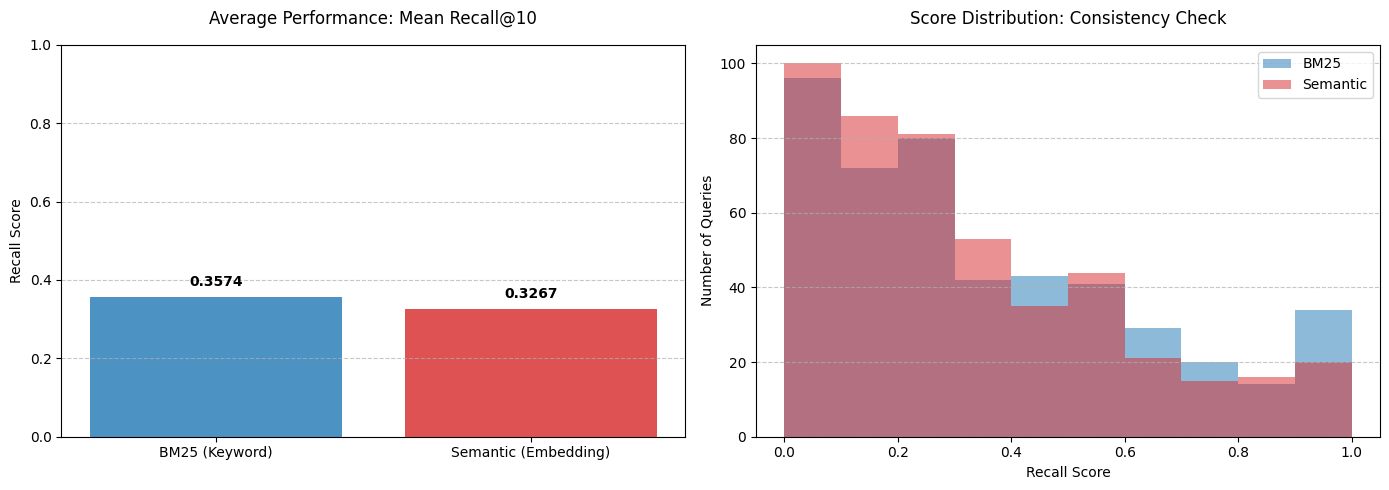

Comparison Summary (471 Queries):
  - Semantic Search 'wins': 123
  - BM25 'wins':            168
  - Ties:                   180


In [31]:
# Visualize comparison
import matplotlib.pyplot as plt

# 1. Prepare Data
methods = ['BM25 (Keyword)', 'Semantic (Embedding)']
mean_scores = [np.mean(bm25_recalls), np.mean(semantic_recalls)]

# 2. Create Figure and Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Bar Chart (The Average) ---
colors = ['#1f77b4', '#d62728']  # Blue and Red
bars = ax1.bar(methods, mean_scores, color=colors, alpha=0.8)

ax1.set_title('Average Performance: Mean Recall@10', fontsize=12, pad=15)
ax1.set_ylabel('Recall Score')
ax1.set_ylim(0, 1.0)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.4f}', ha='center', va='bottom', fontweight='bold')

# --- Plot 2: Histogram (The Distribution) ---
# We use 'stepfilled' or 'histtype' for cleaner overlapping histograms in Matplotlib
ax2.hist(bm25_recalls, bins=10, alpha=0.5, label='BM25', color='#1f77b4', range=(0,1))
ax2.hist(semantic_recalls, bins=10, alpha=0.5, label='Semantic', color='#d62728', range=(0,1))

ax2.set_title('Score Distribution: Consistency Check', fontsize=12, pad=15)
ax2.set_xlabel('Recall Score')
ax2.set_ylabel('Number of Queries')
ax2.legend()
ax2.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- Summary Statistics ---
sem_wins = sum(s > b for s, b in zip(semantic_recalls, bm25_recalls))
bm25_wins = sum(b > s for s, b in zip(semantic_recalls, bm25_recalls))
ties = sum(s == b for s, b in zip(semantic_recalls, bm25_recalls))

print(f"Comparison Summary ({len(valid_queries)} Queries):")
print(f"  - Semantic Search 'wins': {sem_wins}")
print(f"  - BM25 'wins':            {bm25_wins}")
print(f"  - Ties:                   {ties}")

---

## Task 5: Compare Embedding Models (20 points)

### 5a. Embed products with two different models (10 pts)

Compare embeddings from:
- `BAAI/bge-base-en-v1.5`
- `sentence-transformers/all-mpnet-base-v2`

In [32]:
# Load the two embedding models
from sentence_transformers import SentenceTransformer

# 1. Load the BGE-Base model
print("Loading BAAI/bge-base-en-v1.5...")
model_bge = SentenceTransformer('BAAI/bge-base-en-v1.5')

# 2. Load the MPNet-Base model
print("Loading sentence-transformers/all-mpnet-base-v2...")
model_mpnet = SentenceTransformer('all-mpnet-base-v2')

print("Models loaded successfully.")

Loading BAAI/bge-base-en-v1.5...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Loading weights: 100%|██████████| 199/199 [00:00<00:00, 557.60it/s, Materializing param=pooler.dense.weight]                               
BertModel LOAD REPORT from: BAAI/bge-base-en-v1.5
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading sentence-transformers/all-mpnet-base-v2...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Loading weights: 100%|██████████| 199/199 [00:00<00:00, 637.50it/s, Materializing param=pooler.dense.weight]                        
MPNetModel LOAD REPORT from: sentence-transformers/all-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Models loaded successfully.


In [33]:
# Embed products with both models
# 1. Embed using BGE
print("Generating BGE embeddings...")
embeddings_bge = model_bge.encode(
    product_sample['combined_text'].tolist(), 
    show_progress_bar=True,
    batch_size=32
)

# 2. Embed using MPNet
print("Generating MPNet embeddings...")
embeddings_mpnet = model_mpnet.encode(
    product_sample['combined_text'].tolist(), 
    show_progress_bar=True,
    batch_size=32
)

# 3. Store in the dataframe for evaluation
product_sample['embedding_bge'] = list(embeddings_bge)
product_sample['embedding_mpnet'] = list(embeddings_mpnet)

# 4. Compare dimensions
print(f"BGE Embedding Dimension:   {embeddings_bge.shape[1]}")
print(f"MPNet Embedding Dimension: {embeddings_mpnet.shape[1]}")


Generating BGE embeddings...


Batches: 100%|██████████| 157/157 [01:22<00:00,  1.91it/s]


Generating MPNet embeddings...


Batches: 100%|██████████| 157/157 [01:31<00:00,  1.71it/s]

BGE Embedding Dimension:   768
MPNet Embedding Dimension: 768


### 5b. Compare search results between models (10 pts)

Evaluate both models on the same queries and analyze differences.

In [34]:
# List of queries to inspect
test_queries = [
    "comfortable sofa", 
    "star wars rug", 
    "modern coffee table", 
    "ergonomic office chair", 
    "industrial bookshelf"
]

for query in test_queries:
    print(f"\n" + "="*50)
    print(f"QUERY: '{query}'")
    print("="*50)
    
    # Get results from BGE
    res_bge = search_semantic(query, model_bge, embeddings_bge, product_sample, k=3)
    
    # Get results from MPNet
    res_mpnet = search_semantic(query, model_mpnet, embeddings_mpnet, product_sample, k=3)
    
    # Display comparison
    comparison = pd.DataFrame({
        'BGE Top Results': res_bge['product_name'].values,
        'BGE Score': res_bge['score'].values,
        'MPNet Top Results': res_mpnet['product_name'].values,
        'MPNet Score': res_mpnet['score'].values
    })
    display(comparison)


QUERY: 'comfortable sofa'


,BGE Top Results,BGE Score,MPNet Top Results,MPNet Score
0,baeten patio sofa with cushions,0.808783,arshleen patio sofa with cushions,0.747831
1,94 '' square arm sofa with reversible cushions,0.804718,aidann patio sectional with cushions,0.747359
2,mccaffery 74 '' round arm sofa,0.800535,lucey patio sectional with cushions,0.735517



QUERY: 'star wars rug'


,BGE Top Results,BGE Score,MPNet Top Results,MPNet Score
0,dinosaur land area rug,0.778044,runner brandt oriental hand-knotted wool beige area rug,0.613816
1,trisler hand-tufted gray/beige area rug,0.764770,rugsotic carpets hand-knotted silk blue area rug,0.612227
2,dunfries geometric shag gray/white area rug,0.759656,novelty shayne patchwork cowhide leather gradient gray rug,0.608988



QUERY: 'modern coffee table'


,BGE Top Results,BGE Score,MPNet Top Results,MPNet Score
0,coffee table with storage,0.850943,coffee table,0.829269
1,florie solid coffee table,0.845395,updegraff contemporary rect coffee table,0.808302
2,tacto solid wood block coffee table,0.820254,choual coffee table,0.804747



QUERY: 'ergonomic office chair'


,BGE Top Results,BGE Score,MPNet Top Results,MPNet Score
0,mesh ergonomic drafting chair,0.869740,mcglone ergonomic executive chair,0.827761
1,bonaridge ergonomic executive chair,0.867626,bonaridge ergonomic executive chair,0.824460
2,noriko ergonomic task chair,0.859216,noriko ergonomic task chair,0.818035



QUERY: 'industrial bookshelf'


,BGE Top Results,BGE Score,MPNet Top Results,MPNet Score
0,5-tier industrial geet,0.805386,industrail bookcase,0.816021
1,industrail bookcase,0.802662,ryley industrial etagere bookcase,0.773990
2,"industrial wood and metal bookcase with dovetail english front , silver",0.784405,5-tier industrial geet,0.740523


Evaluating 471 queries for both models...


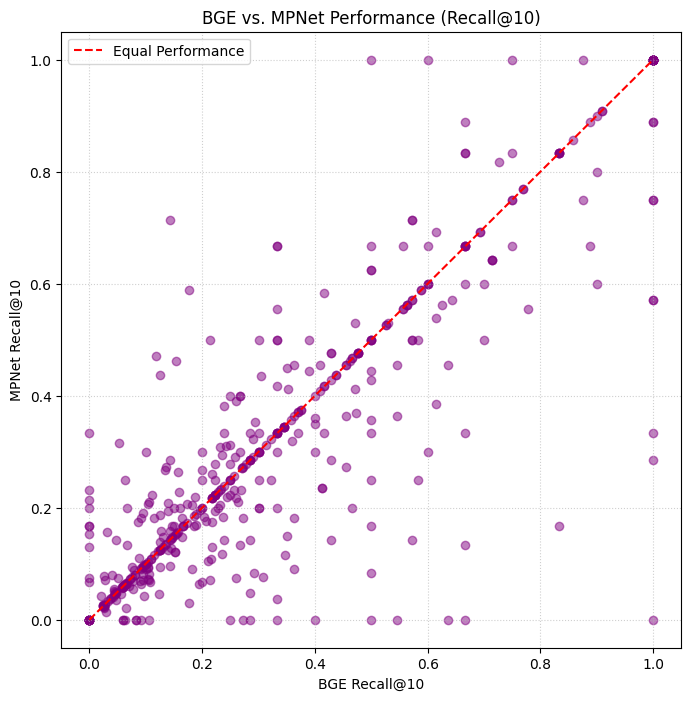

Mean Recall@10 - BGE:   0.3335
Mean Recall@10 - MPNet: 0.3162


In [35]:
# Visualize model comparison with a scatter plot
# X-axis: BGE Recall@10, Y-axis: MPNet Recall@10
import matplotlib.pyplot as plt

# 1. Run evaluation for both models across all valid queries
bge_scores = []
mpnet_scores = []

print(f"Evaluating {len(valid_queries)} queries for both models...")

for q_id, q_text, rel_ids in valid_queries:
    # BGE Recall
    res_bge = search_semantic(q_text, model_bge, embeddings_bge, product_sample, k=10)
    bge_scores.append(calculate_recall(res_bge['product_id'].tolist(), rel_ids, k=10))
    
    # MPNet Recall
    res_mpnet = search_semantic(q_text, model_mpnet, embeddings_mpnet, product_sample, k=10)
    mpnet_scores.append(calculate_recall(res_mpnet['product_id'].tolist(), rel_ids, k=10))

# 2. Create Scatter Plot
plt.figure(figsize=(8, 8))
plt.scatter(bge_scores, mpnet_scores, alpha=0.5, color='purple')

# Add a diagonal line (y=x) to see which model wins
# Dots above the line = MPNet performed better
# Dots below the line = BGE performed better
limit = 1.1
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Equal Performance')

plt.title('BGE vs. MPNet Performance (Recall@10)')
plt.xlabel('BGE Recall@10')
plt.ylabel('MPNet Recall@10')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

# 3. Print final averages
print(f"Mean Recall@10 - BGE:   {np.mean(bge_scores):.4f}")
print(f"Mean Recall@10 - MPNet: {np.mean(mpnet_scores):.4f}")


---

## Task 6: Git Submission (5 points)

Submit your work using the Git workflow:

- [ ] Create a new branch called `homework-4`
- [ ] Commit your work with a meaningful message
- [ ] Push to GitHub
- [ ] Create a Pull Request
- [ ] Merge the PR to main
- [ ] Submit the `.ipynb` file on Blackboard

The TA will verify your submission by checking the merged PR on GitHub.